In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime
import xgboost as xgb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
oil_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")

In [3]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
test_df.sample(15)

,id,date,store_nbr,family,onpromotion
14328,3015216,2017-08-24,11,CELEBRATION,0
5431,3006319,2017-08-19,11,LADIESWEAR,0
13442,3014330,2017-08-23,36,FROZEN FOODS,1
18122,3019010,2017-08-26,18,BREAD/BAKERY,3
23405,3024293,2017-08-29,16,DAIRY,7
396,3001284,2017-08-16,20,AUTOMOTIVE,0
26535,3027423,2017-08-30,53,BEVERAGES,29
11611,3012499,2017-08-22,34,POULTRY,0
22616,3023504,2017-08-28,43,FROZEN FOODS,1
7770,3008658,2017-08-20,27,HOME AND KITCHEN I,0


In [5]:
duplicates = train_df[train_df.duplicated(subset=['date', 'store_nbr', "family"], keep=False)]
duplicates

,id,date,store_nbr,family,sales,onpromotion


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [7]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [8]:
oil_df["date"]=pd.to_datetime(oil_df["date"])

In [34]:
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])

In [10]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [11]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [12]:
correlation_with_prom = train_df["onpromotion"].corr(train_df["sales"])
correlation_with_prom

0.4279232048121313

In [13]:
correlation_with_oil = oil_df["dcoilwtico"].corr(train_df["sales"])
correlation_with_oil
#too low to use this feature in model

-0.049346765971872424

In [14]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [15]:
train_df = train_df.merge(stores_df, on="store_nbr", how="left").drop("id", axis=1)
test_df = test_df.merge(stores_df, on="store_nbr", how="left").drop("id", axis=1)

In [16]:
train_df.sample(10)

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
715824,2014-02-07,43,LINGERIE,4.000,0,Esmeraldas,Esmeraldas,E,10
2510206,2016-11-12,40,POULTRY,126.731,0,Machala,El Oro,C,3
2975560,2017-08-01,48,HOME AND KITCHEN II,45.000,1,Quito,Pichincha,A,14
404119,2013-08-15,48,BABY CARE,0.000,0,Quito,Pichincha,A,14
1959235,2016-01-08,31,PERSONAL CARE,337.000,0,Babahoyo,Los Rios,B,10
1445508,2015-03-25,18,DELI,270.277,0,Quito,Pichincha,B,16
1153426,2014-10-11,22,EGGS,0.000,0,Puyo,Pastaza,C,7
56896,2013-02-01,6,BOOKS,0.000,0,Quito,Pichincha,D,13
2943552,2017-07-14,5,HOME CARE,258.000,13,Santo Domingo,Santo Domingo de los Tsachilas,D,4
1039801,2014-08-08,34,BOOKS,0.000,0,Guayaquil,Guayas,B,6


In [17]:
avg_sales_by_city= train_df.groupby("city")["sales"].mean().sort_values().reset_index()
avg_sales_by_city

,city,sales
0,Puyo,73.601845
1,Manta,125.173982
2,Playas,138.139340
3,Latacunga,190.583961
4,El Carmen,198.975799
5,Riobamba,204.921881
6,Salinas,205.517129
7,Ibarra,206.061866
8,Santo Domingo,214.942315
9,Guaranda,234.821670


Text(0, 0.5, 'Average sales')

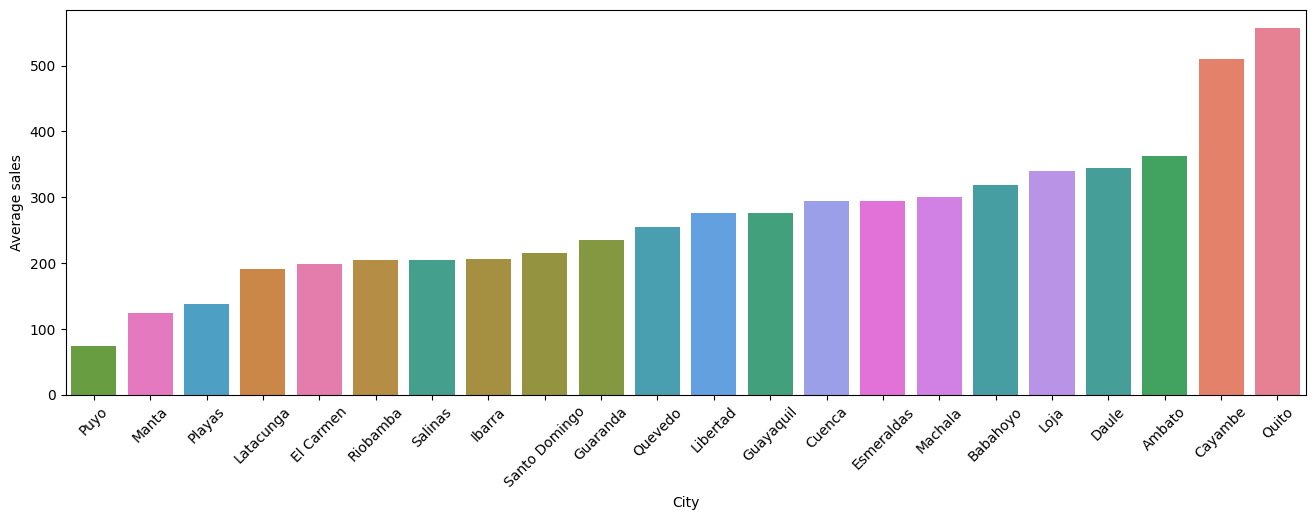

In [18]:
unique_cities = train_df['city'].unique()
color_palette = dict(zip(unique_cities, sns.color_palette("husl", n_colors=len(unique_cities))))
plt.figure(figsize=(16,5))
sns.barplot(x="city", y="sales", data=avg_sales_by_city, palette=color_palette)
plt.xticks(rotation=45)
plt.xlabel("City")
plt.ylabel("Average sales")



In [19]:
sorted_stores = train_df.groupby('store_nbr')['sales'].mean().sort_values().index
store_to_city = train_df.groupby('store_nbr')['city'].first()
store_colors = [color_palette[store_to_city[store]] for store in sorted_stores]

Text(0, 0.5, 'Average sales')

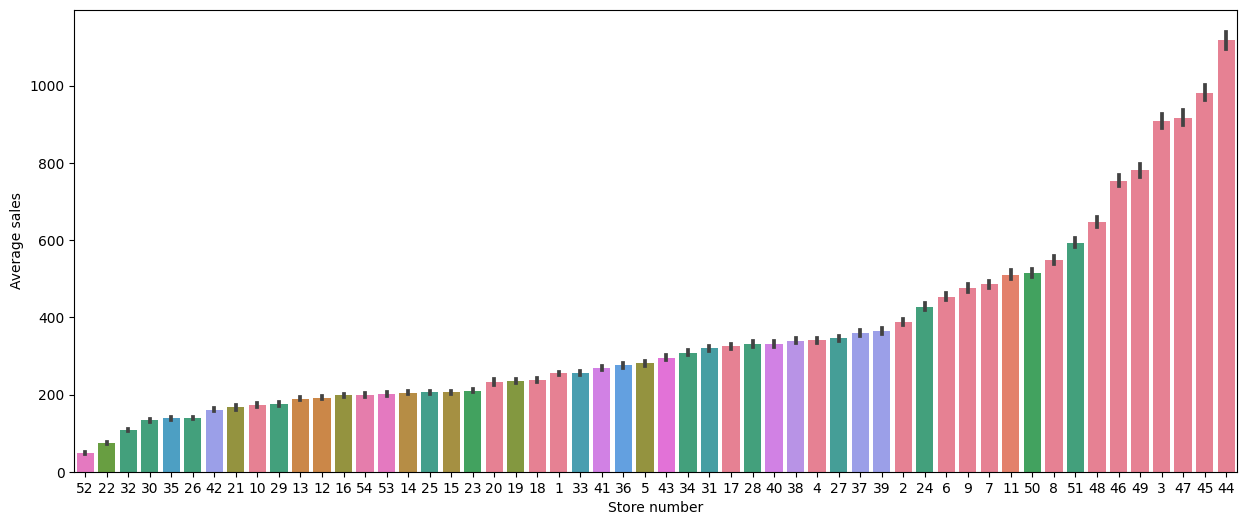

In [20]:
plt.figure(figsize=(15,6))
sns.barplot(data=train_df, x="store_nbr", y="sales", order=sorted_stores, palette=store_colors)
plt.xlabel("Store number")
plt.ylabel("Average sales")
#there's a clear connection between sales number and city where the store is located, but using only the store number is likely giving 
#a better result if its broken down into fewer categories based on sales volume, because of the individual differences in a city


In [21]:
avg_sales_by_store = train_df.groupby('store_nbr')['sales'].mean().sort_values().reset_index()

In [22]:
bins = [0, 100, 150, 200, 300, 400, 500, 600, 800, 1000, 1120]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
avg_sales_by_store['store_cat'] = pd.cut(avg_sales_by_store['sales'], bins=bins, labels=labels, include_lowest=True)

In [23]:
store_cat_dict = dict(zip(avg_sales_by_store['store_nbr'], avg_sales_by_store['store_cat']))
train_df["store_nbr"] = train_df['store_nbr'].map(store_cat_dict)
test_df["store_nbr"] = test_df["store_nbr"].map(store_cat_dict)

In [24]:
train_df.sample(20)

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
1266397,2014-12-13,3,"LIQUOR,WINE,BEER",263.000000,0,Machala,El Oro,D,4
2347647,2016-08-13,8,PLAYERS AND ELECTRONICS,24.000000,0,Quito,Pichincha,D,8
791984,2014-03-22,1,HOME APPLIANCES,0.000000,0,Guayaquil,Guayas,C,3
2903335,2017-06-22,2,POULTRY,100.923996,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6
485168,2013-09-30,0,BEAUTY,0.000000,0,Puyo,Pastaza,C,7
536086,2013-10-28,6,BABY CARE,0.000000,0,Ambato,Tungurahua,A,14
574501,2013-11-19,2,BOOKS,0.000000,0,Guayaquil,Guayas,E,10
42233,2013-01-24,3,PET SUPPLIES,0.000000,0,Esmeraldas,Esmeraldas,E,10
1133340,2014-09-29,5,LINGERIE,10.000000,0,Quito,Pichincha,B,6
170241,2013-04-06,1,PLAYERS AND ELECTRONICS,0.000000,0,Playas,Guayas,C,3


<Axes: xlabel='family', ylabel='sales'>

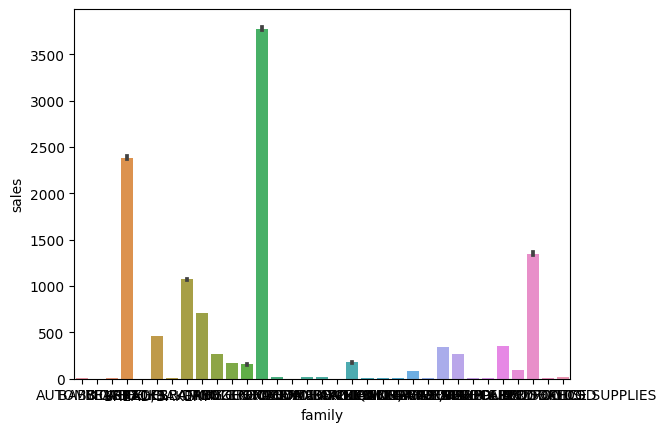

In [25]:
sns.barplot(data=train_df, x="family", y="sales")

In [26]:
avg_sales_by_family= train_df.groupby("family")["sales"].mean().sort_values().reset_index()
avg_sales_by_family

,family,sales
0,BOOKS,0.070797
1,BABY CARE,0.110528
2,HOME APPLIANCES,0.457476
3,HARDWARE,1.137833
4,MAGAZINES,2.929082
5,SCHOOL AND OFFICE SUPPLIES,2.961599
6,BEAUTY,3.715723
7,PET SUPPLIES,3.921263
8,LAWN AND GARDEN,6.035475
9,AUTOMOTIVE,6.101236


In [27]:
bins = [0, 5, 10, 80, 100, 200, 500, 1100, 1400, 2400, 3800]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
avg_sales_by_family['family_cat'] = pd.cut(avg_sales_by_family['sales'], bins=bins, labels=labels, include_lowest=True)

In [28]:
avg_sales_by_family

,family,sales,family_cat
0,BOOKS,0.070797,0
1,BABY CARE,0.110528,0
2,HOME APPLIANCES,0.457476,0
3,HARDWARE,1.137833,0
4,MAGAZINES,2.929082,0
5,SCHOOL AND OFFICE SUPPLIES,2.961599,0
6,BEAUTY,3.715723,0
7,PET SUPPLIES,3.921263,0
8,LAWN AND GARDEN,6.035475,1
9,AUTOMOTIVE,6.101236,1


In [29]:
family_cat_dict = dict(zip(avg_sales_by_family['family'], avg_sales_by_family['family_cat']))
train_df["family"] = train_df['family'].map(family_cat_dict)
test_df["family"] = test_df["family"].map(family_cat_dict)

In [30]:
train_df.sample(15)

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
502081,2013-10-09,7,1,0.000,0,Quito,Pichincha,A,14
2888652,2017-06-14,3,7,3818.976,204,Quito,Pichincha,D,13
456794,2013-09-14,1,6,182.000,0,Guayaquil,Guayas,D,10
587132,2013-11-26,1,3,14.000,0,Guayaquil,Guayas,C,3
891552,2014-05-17,5,5,0.000,0,Guayaquil,Guayas,D,1
2749596,2017-03-27,5,8,3694.000,16,Quito,Pichincha,B,6
653985,2014-01-03,5,5,348.890,0,Quito,Pichincha,B,6
821945,2014-04-08,2,0,0.000,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6
2321165,2016-07-29,4,4,148.725,1,Cuenca,Azuay,D,2
1885315,2015-11-26,6,5,199.000,0,Quito,Pichincha,D,8


In [31]:
def create_features(df_):
    df = df_.copy()
    
    df["month"] = df.date.dt.month
    df["year"] = df.date.dt.year
    df["quarter"] = df.date.dt.quarter
    df['dayofweek'] = df.date.dt.dayofweek
    
    return df

In [35]:
train_df_ = create_features(train_df)
test_df = create_features(test_df)

In [36]:
test_df

,date,store_nbr,family,onpromotion,city,state,type,cluster,month,year,quarter,dayofweek
0,2017-08-16,3,1,0,Quito,Pichincha,D,13,8,2017,3,2
1,2017-08-16,3,0,0,Quito,Pichincha,D,13,8,2017,3,2
2,2017-08-16,3,0,2,Quito,Pichincha,D,13,8,2017,3,2
3,2017-08-16,3,8,20,Quito,Pichincha,D,13,8,2017,3,2
4,2017-08-16,3,0,0,Quito,Pichincha,D,13,8,2017,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,5,5,1,Quito,Pichincha,B,6,8,2017,3,3
28508,2017-08-31,5,3,0,Quito,Pichincha,B,6,8,2017,3,3
28509,2017-08-31,5,7,1,Quito,Pichincha,B,6,8,2017,3,3
28510,2017-08-31,5,0,9,Quito,Pichincha,B,6,8,2017,3,3


In [38]:
X_train = train_df_.drop(["city", "state", "type", "cluster", "date"], axis=1).copy()
X_test = test_df.drop(["city", "state", "type", "cluster", "date"], axis=1)
y_train = X_train.pop("sales")

In [39]:
X_test

,store_nbr,family,onpromotion,month,year,quarter,dayofweek
0,3,1,0,8,2017,3,2
1,3,0,0,8,2017,3,2
2,3,0,2,8,2017,3,2
3,3,8,20,8,2017,3,2
4,3,0,0,8,2017,3,2
...,...,...,...,...,...,...,...
28507,5,5,1,8,2017,3,3
28508,5,3,0,8,2017,3,3
28509,5,7,1,8,2017,3,3
28510,5,0,9,8,2017,3,3


In [3]:
model = xgb.XGBRegressor()